## Семинар 4: "Сверточные сети"

ФИО: 

In [2]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [3]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(signal.shape[0]-kernel.shape[0]+1)
    for i in range(signal_convolved.shape[0]):
        signal_convolved[i] = np.dot(signal[i:i+kernel.shape[0]], kernel[::-1])
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [4]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

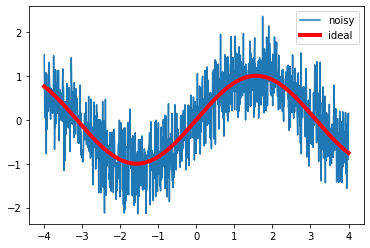

In [5]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [6]:
kernel = np.ones(shape=(20)) / 20
denoised_signal = convolve(noisy_signal, kernel, 'same')

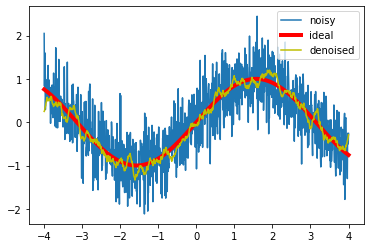

In [7]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [8]:
for size in range(3, 999, 2):
    kernel = np.ones(size)
    kernel /= kernel.shape[0]

    denoised_signal = convolve(noisy_signal, kernel, 'same')    
    error = ((signal - denoised_signal)**2).mean()
    
    print("ks = {}, error = {}".format(size, error))

ks = 3, error = 0.06811839157929737
ks = 5, error = 0.038387088838214074
ks = 7, error = 0.02646621923301913
ks = 9, error = 0.019914054736563897
ks = 11, error = 0.016263741431872616
ks = 13, error = 0.013945161895461177
ks = 15, error = 0.012211550234367515
ks = 17, error = 0.010850404172483646
ks = 19, error = 0.009963582128651944
ks = 21, error = 0.009095554793433432
ks = 23, error = 0.008257474927208712
ks = 25, error = 0.0075436195348413376
ks = 27, error = 0.007070674141223336
ks = 29, error = 0.006651927384628954
ks = 31, error = 0.0063121097736895185
ks = 33, error = 0.006038670192216703
ks = 35, error = 0.0058374185289506875
ks = 37, error = 0.005701144883879702
ks = 39, error = 0.005595815380615656
ks = 41, error = 0.0055597242036646045
ks = 43, error = 0.005520937834769696
ks = 45, error = 0.005499747379819781
ks = 47, error = 0.00550152450699712
ks = 49, error = 0.005521707813261077
ks = 51, error = 0.00555850925013694
ks = 53, error = 0.00563745581387224
ks = 55, error = 

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [9]:
image = plt.imread('shrek.jpg')
image.shape

(720, 1280, 3)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [10]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

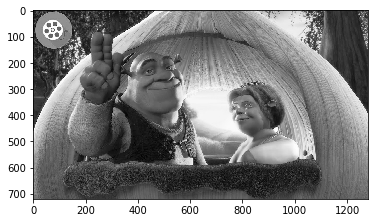

In [11]:
bw_image = convolve(image.flatten(), color_to_bw, 'same')[::3].reshape(*image.shape[:2])
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [12]:
from scipy.signal import convolve2d

kernel = np.array([[-1, -2, -1],
                   [0,   0,  0],
                   [+1, +2, +1]])

res_y = convolve2d(bw_image, kernel.T, 'same')
res_x = convolve2d(bw_image, kernel, 'same')

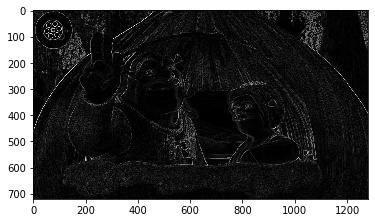

In [13]:
plt.imshow((res_x**2 + res_y**2)**0.5, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [14]:
def t_convolve_bank(signal, kernel):
    assert signal.shape[-1] == kernel.shape[0]
    
    res = []
    for i in range(kernel.shape[-1]):
        r = np.zeros_like(signal[:, :, i])
        for j in range(signal.shape[-1]):
            r += convolve2d(signal[:, :, j], kernel[j, :, :, i], 'same')            
        
        res.append(r)
    
    return np.array(res).transpose((1, 2, 0))

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [15]:
kernels = np.zeros((3, 1, 1, 3))

kernels[0, 0, 0, 2] = 1

kernels[1, 0, 0, 1] = 1

kernels[2, 0, 0, 0] = 1
kernels

array([[[[0., 0., 1.]]],


       [[[0., 1., 0.]]],


       [[[1., 0., 0.]]]])

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

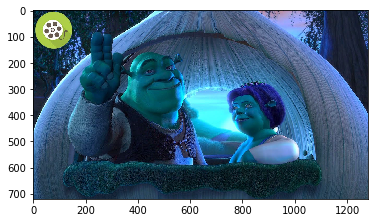

In [16]:
res_image = t_convolve_bank(image.astype(float), kernels)

plt.imshow(res_image.astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [17]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.max(image[i:i+w, j:j+w, k])
    return res

def medianpool(image, w=2):
    assert(image.ndim == 3)
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.median(image[i:i+w, j:j+w, k])
                
    return res

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

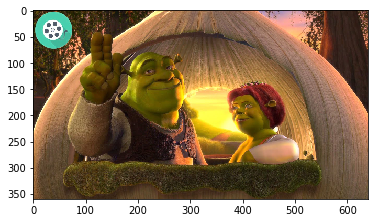

In [18]:
res_image = maxpool(image.astype(float))

plt.imshow(res_image.astype('uint8'))

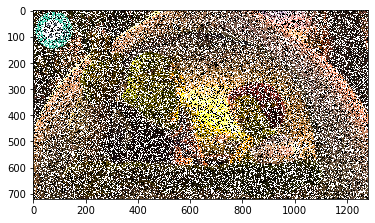

In [19]:
frac = 0.7

res_image = np.array(image)

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 0

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 255

plt.imshow(res_image.astype('uint8'))

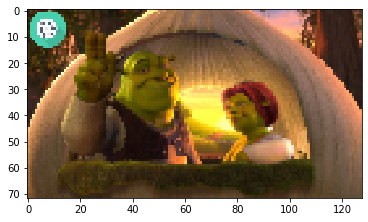

In [20]:
clean_image = medianpool(res_image.astype(float), 10)

plt.imshow(clean_image.astype('uint8'))

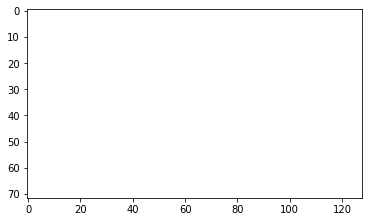

In [21]:
clean_image = maxpool(res_image.astype(float), 10)

plt.imshow(clean_image.astype('uint8'))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Медианный пулинг справился лучше так как брал среднее значение для каждого пикселя,
тем самым избегая локальных искажений. Максимальный пулинг не сработал, так как может игнорировать
значения окружающих пикселей, когда ловит в некотором диапазоне пикселя искажение с максимальным значением.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [180]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [26]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [27]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.237/0.220	Accuracy: 0.932/0.936


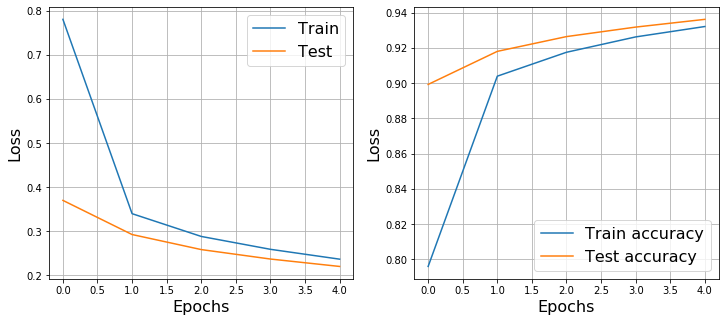

In [33]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [34]:
in_channels_1 = 1
out_channels_1 = 8
kernel_size_1 = (3, 3)

in_channels_2 = 8
out_channels_2 = 16
kernel_size_2 = (3, 3)

class ConvClassifier_1(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_1, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels_1, out_channels_1, kernel_size_1, padding=1), 
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(in_channels_2, out_channels_2, kernel_size_2, padding=1),
                                         nn.ReLU())

        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.086/0.075	Accuracy: 0.975/0.978


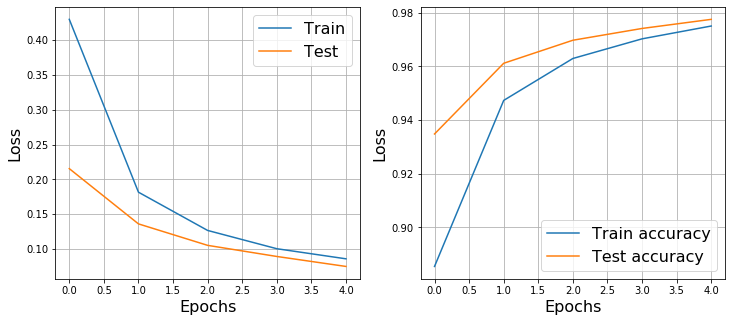

In [35]:
network_1 = ConvClassifier_1(image_size=28)
train(network_1, 5, 1e-4)

In [36]:
in_channels_1 = 1
out_channels_1 = 8
kernel_size_1 = (3, 3)

in_channels_2 = 8
out_channels_2 = 16
kernel_size_2 = (3, 3)

in_channels_3 = 16
out_channels_3 = 32
kernel_size_3 = (3, 3)

class ConvClassifier_2(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels_1, out_channels_1, kernel_size_1, padding=1), 
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels_2, out_channels_2, kernel_size_2, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(in_channels_3, out_channels_3, kernel_size_3, padding=1))

        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*32, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.067/0.057	Accuracy: 0.980/0.982


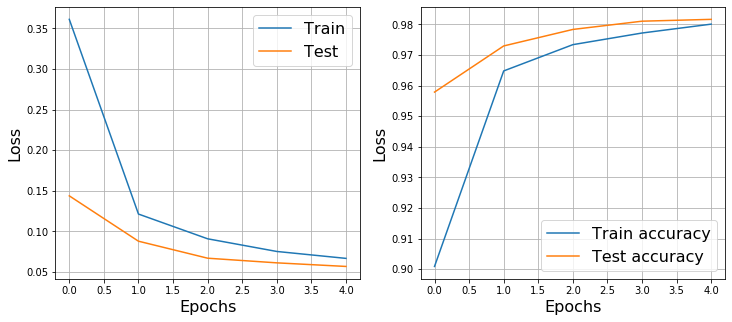

In [37]:
network_2 = ConvClassifier_2(image_size=28)
train(network_2, 5, 1e-4)

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

In [173]:
def print_worst(count_of_bad_predictions, loader, network, loss=nn.NLLLoss()):
    losses = []
    accuracies = []
    list_X = []
    list_y = []
    
    for X, y in s_test_loader:
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.item())
        accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
        list_X.append(X)
        list_y.append(y[0])
        
    data_y = np.array(list_y)
    losses = np.array(losses)
    accuracies = np.array(accuracies)
    
    ind = losses.argsort()[-count_of_bad_predictions:]
    worst_targets = data_y[ind]
    worst_X = []

    for index in ind:
        worst_X.append(list_X[index])

    worst_predictions = []
    worst_images = np.zeros(shape=(count_of_bad_predictions, 784))

    for index in ind:
        worst_predictions.append(np.argmax(network_1.forward(list_X[index]).data.numpy(), 1))

    for i in range(count_of_bad_predictions):
        for j in range(784):
            worst_images[i, j] = worst_X[i][0].flatten()[j]
    
    plt.figure(figsize=(16, 17))
    for i in range(count_of_bad_predictions):
        plt.subplot(4, 3, i+1)
        plt.imshow(worst_images[i].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title("real: " + str(worst_targets[i]) + "   pred: " + str(worst_predictions[i][0]))
        plt.axis('off')
    
    return ind

In [174]:
s_test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

array([4621, 4853, 2162,  236, 5911, 3540, 2590, 8860, 3853, 3100, 4084,
       2028])

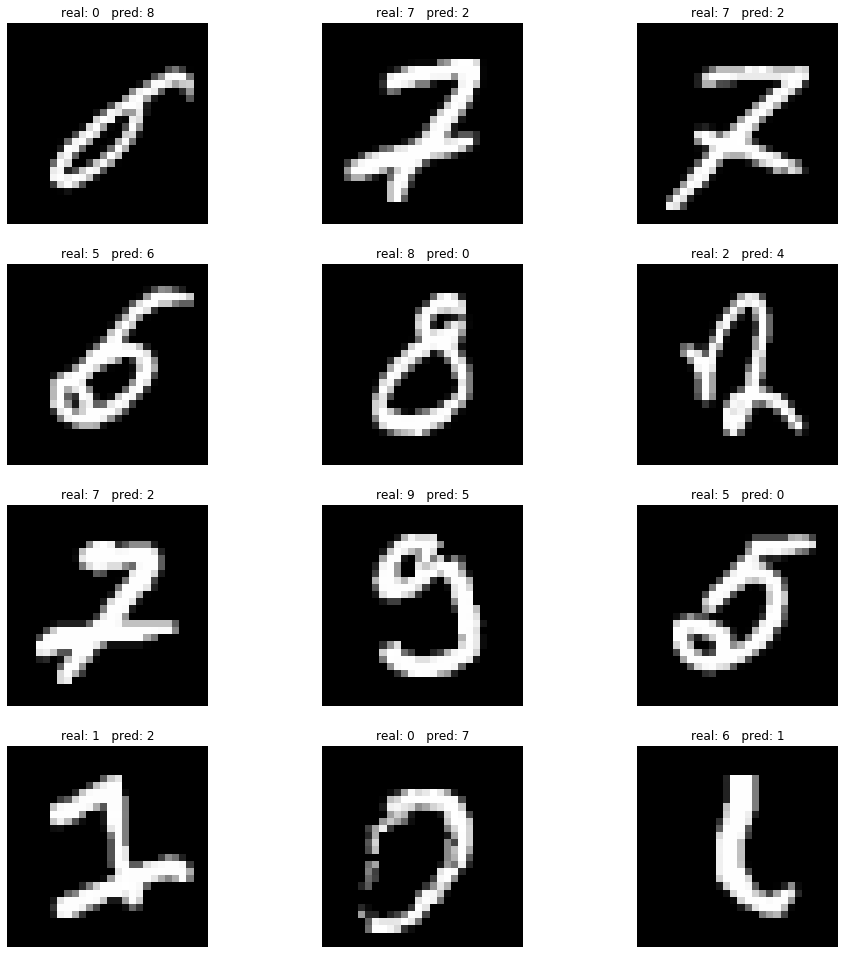

In [175]:
print_worst(12, s_test_loader, network_1, nn.NLLLoss())

array([3655, 8458, 2942,  747, 5764, 3263, 8332, 4483, 7673, 9598, 7608,
       9493])

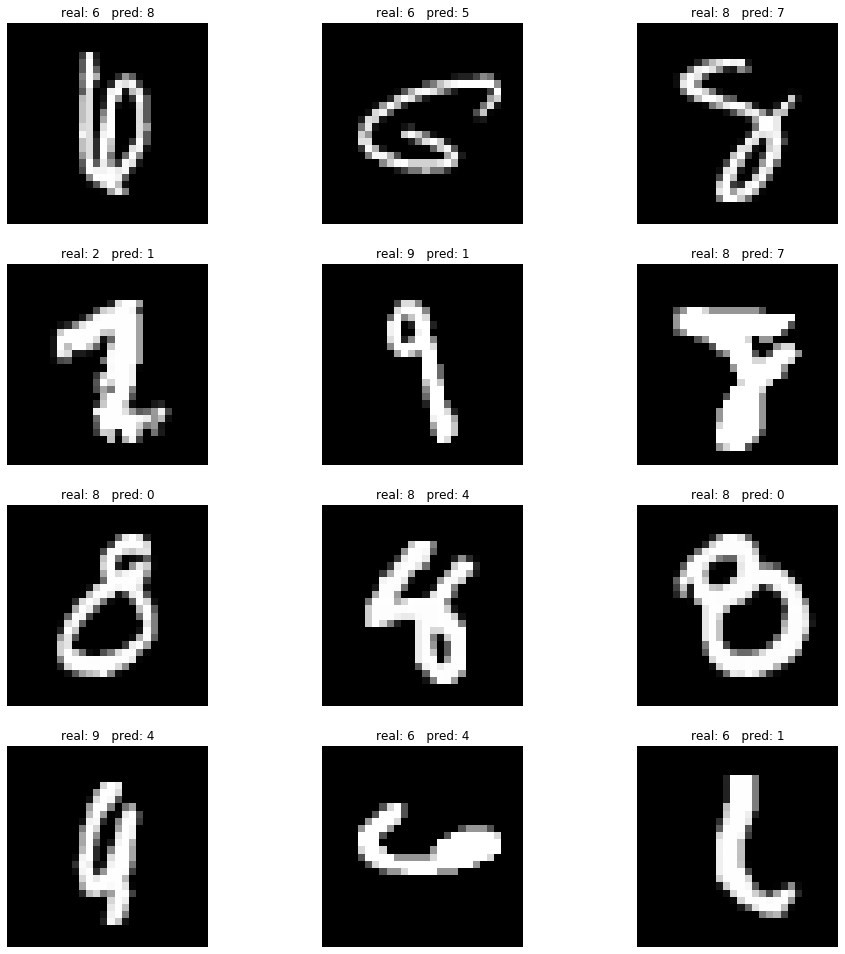

In [176]:
print_worst(12, s_test_loader, network_2, nn.NLLLoss())

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [188]:
in_channels_1 = 1
out_channels_1 = 4
kernel_size_1 = (3, 3)

in_channels_2 = 4
out_channels_2 = 8
kernel_size_2 = (3, 3)

in_channels_3 = 8
out_channels_3 = 16
kernel_size_3 = (3, 3)

class ConvClassifier_3(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_3, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels_1, out_channels_1, kernel_size_1, padding=1), 
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels_2, out_channels_2, kernel_size_2, padding=1),
                                         nn.ELU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(in_channels_3, out_channels_3, kernel_size_3, padding=1))

        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 50), 
                                           nn.Tanh(),
                                           nn.Linear(50, 10), 
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.083/0.072	Accuracy: 0.978/0.979


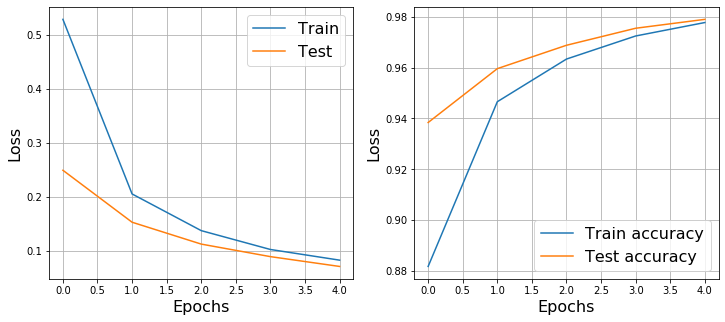

In [189]:
network_3 = ConvClassifier_3(image_size=28)
train(network_3, 5, 1e-4)

Epoch 9... (Train/Test) NLL: 0.050/0.061	Accuracy: 0.987/0.981


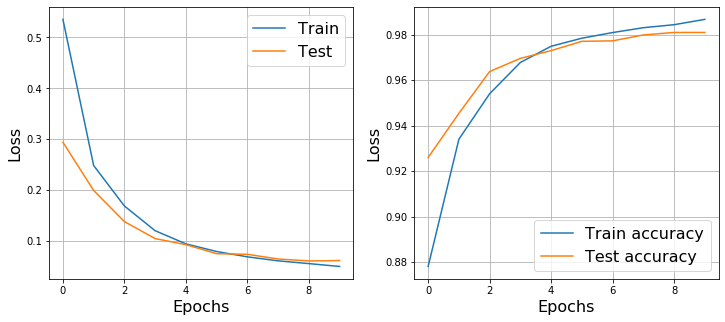

In [191]:
network_4 = ConvClassifier_3(image_size=28)
train(network_4, 10, 1.e-4)

In [195]:
in_channels_1 = 1
out_channels_1 = 8
kernel_size_1 = (3, 3)

in_channels_2 = 8
out_channels_2 = 16
kernel_size_2 = (3, 3)

class ConvClassifier_4(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_4, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels_1, out_channels_1, kernel_size_1, padding=1), 
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(in_channels_2, out_channels_2, kernel_size_2, padding=1),
                                         nn.ReLU())

        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 100), 
                                           nn.ELU(),
                                           nn.Linear(100, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.025/0.038	Accuracy: 0.992/0.988


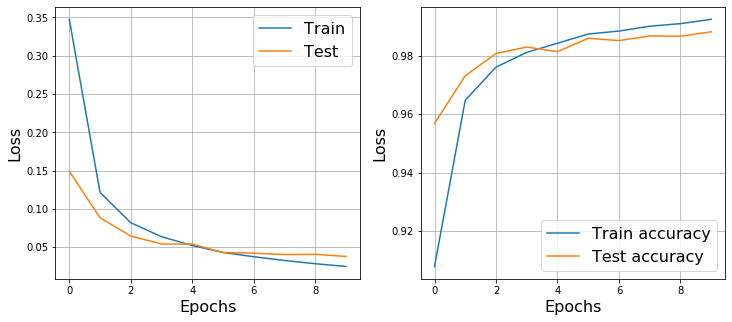

In [196]:
network_5 = ConvClassifier_4(image_size=28)
train(network_5, 10, 1.e-4)

Epoch 5... (Train/Test) NLL: 0.044/0.048	Accuracy: 0.986/0.985


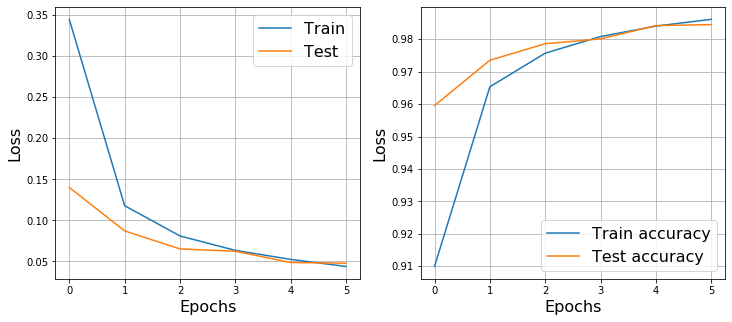

In [197]:
network_6 = ConvClassifier_4(image_size=28)
train(network_6, 6, 1.e-4)

In [200]:
in_channels_1 = 1
out_channels_1 = 4
kernel_size_1 = (3, 3)

in_channels_2 = 4
out_channels_2 = 8
kernel_size_2 = (3, 3)

class ConvClassifier_5(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier_5, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels_1, out_channels_1, kernel_size_1, padding=1), 
                                         nn.ELU(),
                                         nn.Conv2d(in_channels_2, out_channels_2, kernel_size_2, padding=1),
                                         nn.MaxPool2d(2),
                                         nn.Tanh())

        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*8, 70), 
                                           nn.ELU(),
                                           nn.Linear(70, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.077/0.075	Accuracy: 0.978/0.977


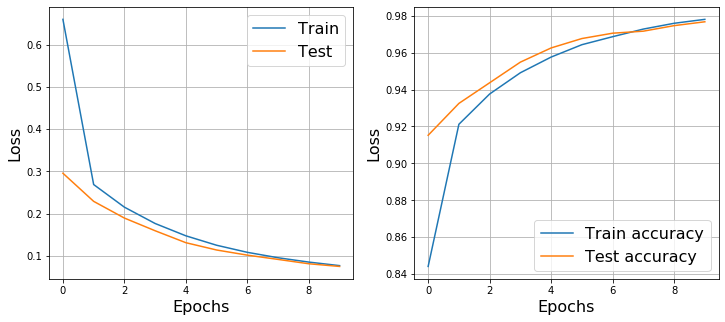

In [201]:
network_7 = ConvClassifier_5(image_size=28)
train(network_7, 10, 6.e-5)

Epoch 5... (Train/Test) NLL: 0.091/0.086	Accuracy: 0.974/0.975


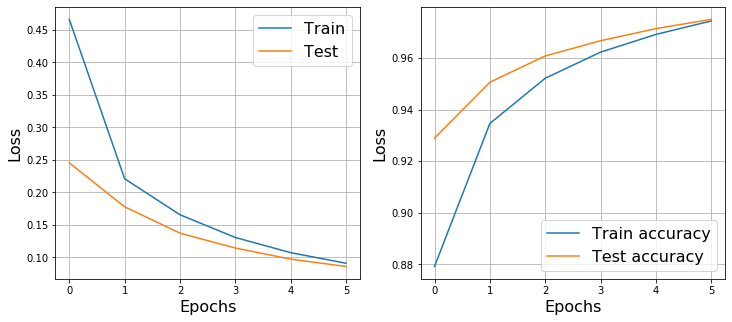

In [202]:
network_8 = ConvClassifier_5(image_size=28)
train(network_8, 6, 1.e-4)

Результат экспериментов: Улучшить результат удалось.

Архитектура: input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel ->
-> Linear -> ELU -> Linear -> LogSoftmax

Параметры обучения: Количество эпох = 10, Скорость обучения = 1.e-4

Результат:

        network_5:      NLL: 0.025/0.038	Accuracy: 0.992/0.988 
        
против 

        network_1:      NLL: 0.086/0.075	Accuracy: 0.975/0.978
        network_2:      NLL: 0.067/0.057	Accuracy: 0.980/0.982


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: